In [1]:
import yfinance as yf

from prophet import Prophet

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import plotly.graph_objs as go

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--> Fetching data

In [2]:
start_date = '2020-01-02'

end_date = '2022-01-01'

train_end_date = '2021-12-15'

In [3]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG', 'VTI']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Take a look at the data
data.head()

[*********************100%***********************]  2 of 2 completed


Price           Close            
Ticker           GOOG         VTI
Date                             
2020-01-02  68.123726  152.903961
2020-01-03  67.789421  151.930801
2020-01-06  69.460922  152.449844
2020-01-07  69.417580  152.088379
2020-01-08  69.964615  152.839081

In [4]:
data.columns = data.columns.droplevel(0)

data.head()

Ticker,GOOG,VTI
Date,,
2020-01-02,68.123726,152.903961
2020-01-03,67.789421,151.930801
2020-01-06,69.460922,152.449844
2020-01-07,69.417580,152.088379
2020-01-08,69.964615,152.839081


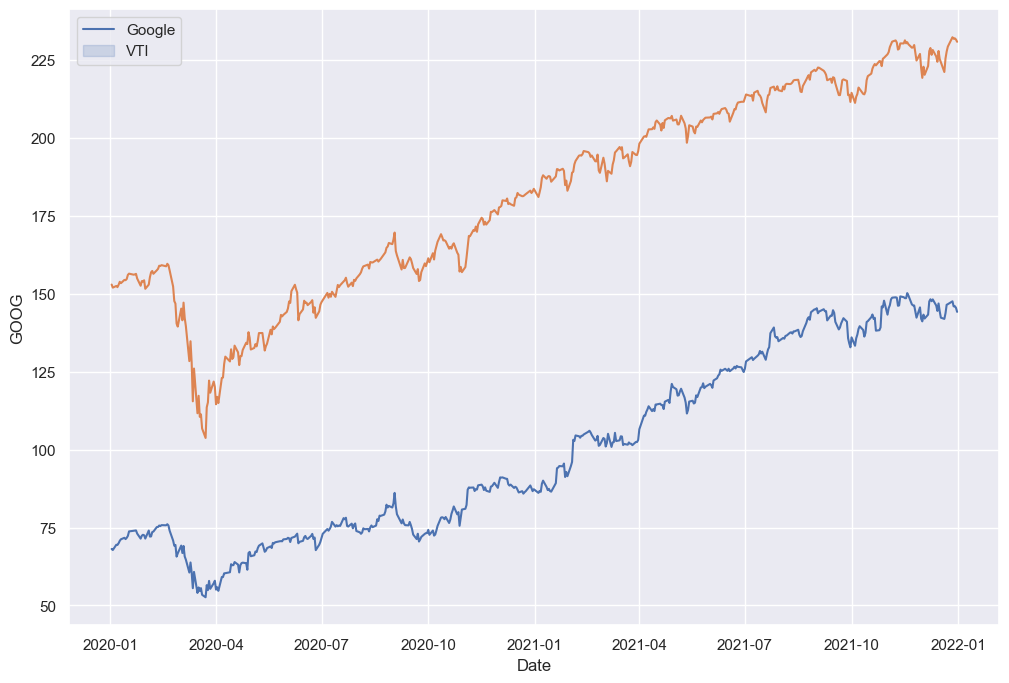

In [5]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['VTI'])
plt.legend(['Google', 'VTI'])

--> Data Preprocessing

In [6]:
data = data.reset_index()
data.columns = ['ds', 'y', 'VTI']

data.head()

,ds,y,VTI
0,2020-01-02,68.123726,152.903961
1,2020-01-03,67.789421,151.930801
2,2020-01-06,69.460922,152.449844
3,2020-01-07,69.417580,152.088379
4,2020-01-08,69.964615,152.839081


In [7]:
data.corrwith(data['y'])

ds     0.961303
y      1.000000
VTI    0.969671
dtype: float64

--> Splitting the dataset

In [8]:
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]

print(train.shape, test.shape)

(494, 3) (11, 3)


In [9]:
train

,ds,y,VTI
0,2020-01-02,68.123726,152.903961
1,2020-01-03,67.789421,151.930801
2,2020-01-06,69.460922,152.449844
3,2020-01-07,69.417580,152.088379
4,2020-01-08,69.964615,152.839081
...,...,...,...
489,2021-12-09,147.575760,226.571701
490,2021-12-10,148.142715,228.114487
491,2021-12-13,146.179260,226.038391
492,2021-12-14,144.451477,224.343201


In [10]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-01-02 00:00:00
The end time of the training dataset is  2021-12-15 00:00:00
The start time of the testing dataset is  2021-12-16 00:00:00
The end time of the testing dataset is  2021-12-31 00:00:00


--> Building a univariate baseline model. Although the dataset has an additional column 'VTI', the model discussed below will ignore it.The extra column will be handled in a later model

In [11]:
model_baseline = Prophet()

model_baseline.fit(train)

11:13:39 - cmdstanpy - INFO - Chain [1] start processing
11:13:39 - cmdstanpy - INFO - Chain [1] done processing


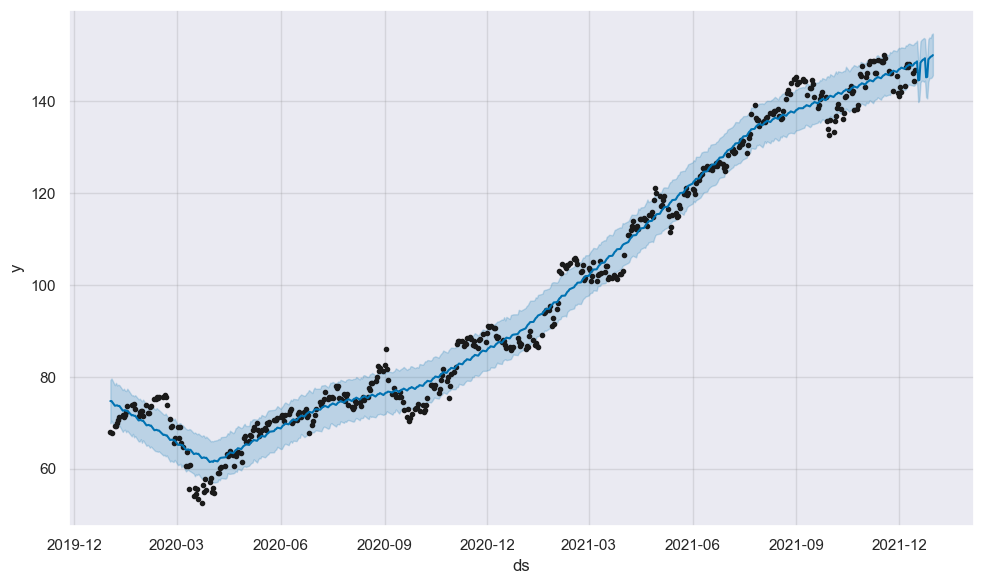

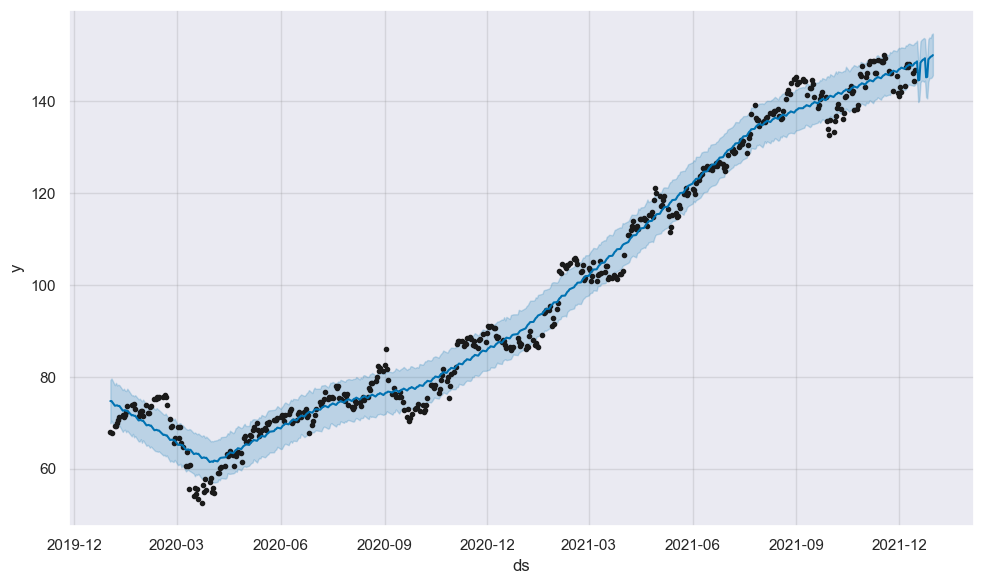

In [12]:
future_baseline = model_baseline.make_future_dataframe(periods=16)

forecast_baseline = model_baseline.predict(future_baseline)

model_baseline.plot(forecast_baseline)

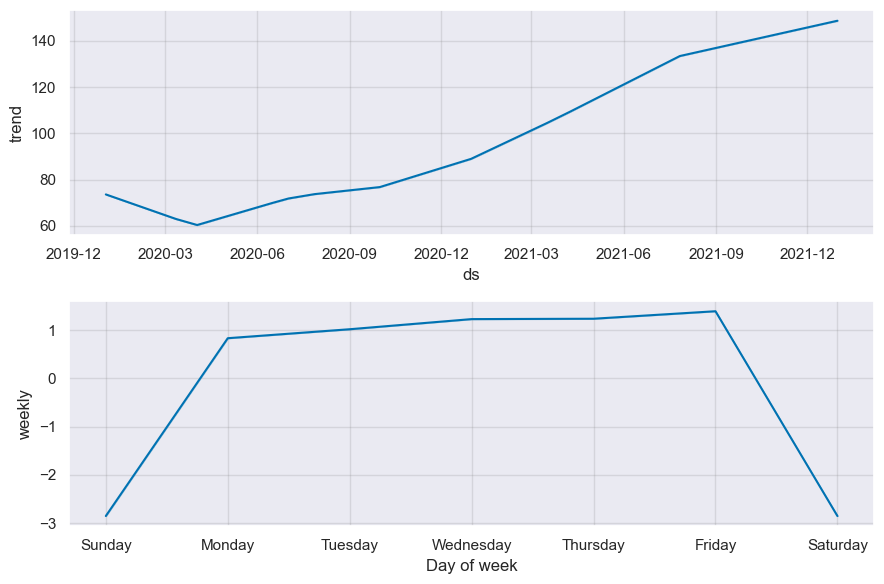

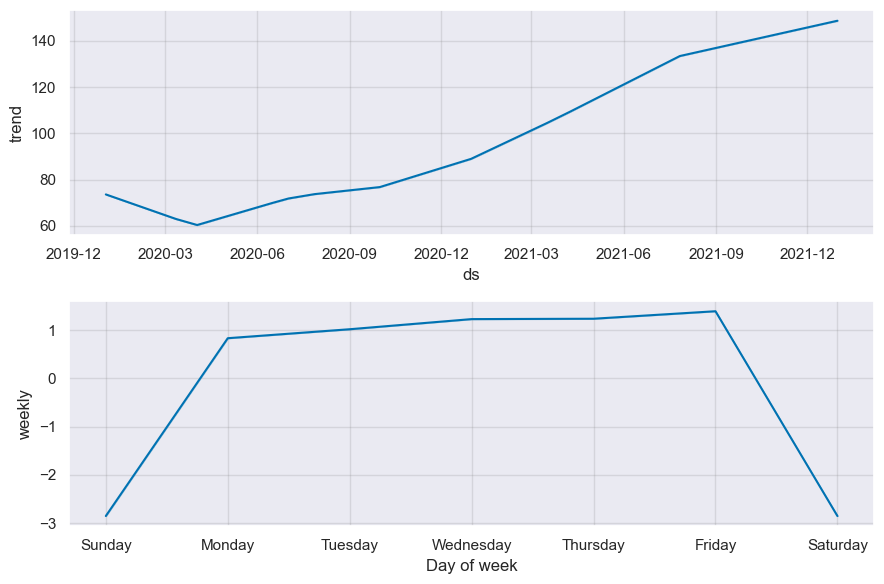

In [13]:
model_baseline.plot_components(forecast_baseline)

--> Baseline model performance

In [14]:
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(performance_baseline_MAE)

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(performance_baseline_MAPE)

4.233127878352491
0.029333842700463797


--> Building model with seasonality

In [15]:
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)

model_season.fit(train)

11:13:40 - cmdstanpy - INFO - Chain [1] start processing
11:13:40 - cmdstanpy - INFO - Chain [1] done processing


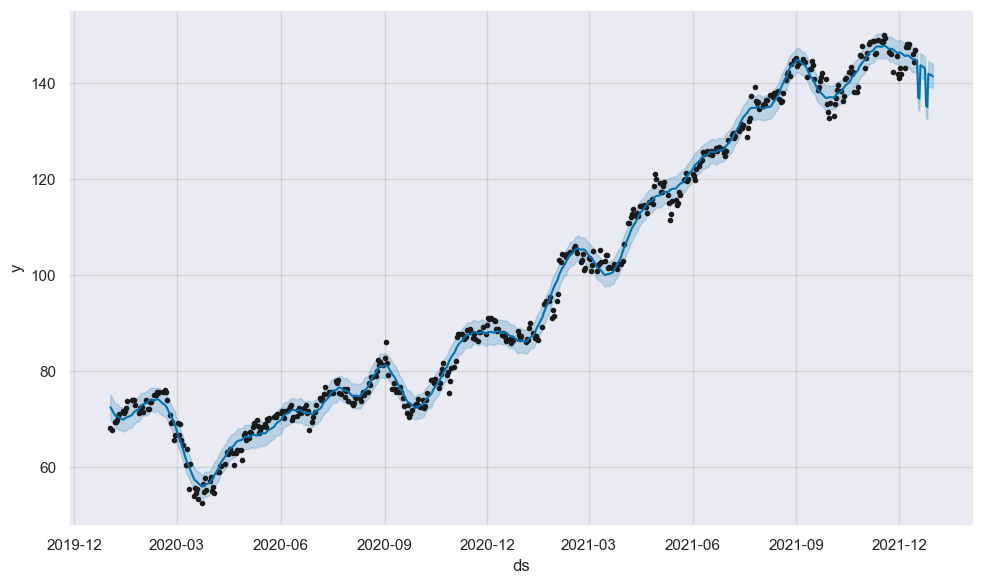

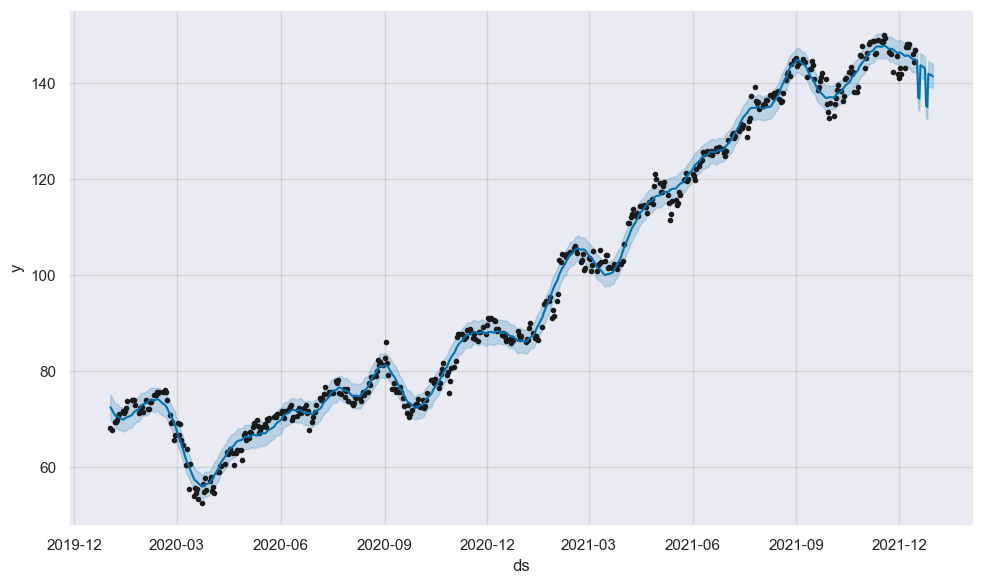

In [16]:
future_season = model_season.make_future_dataframe(periods=16)

forecast_season = model_season.predict(future_season)

model_season.plot(forecast_season)

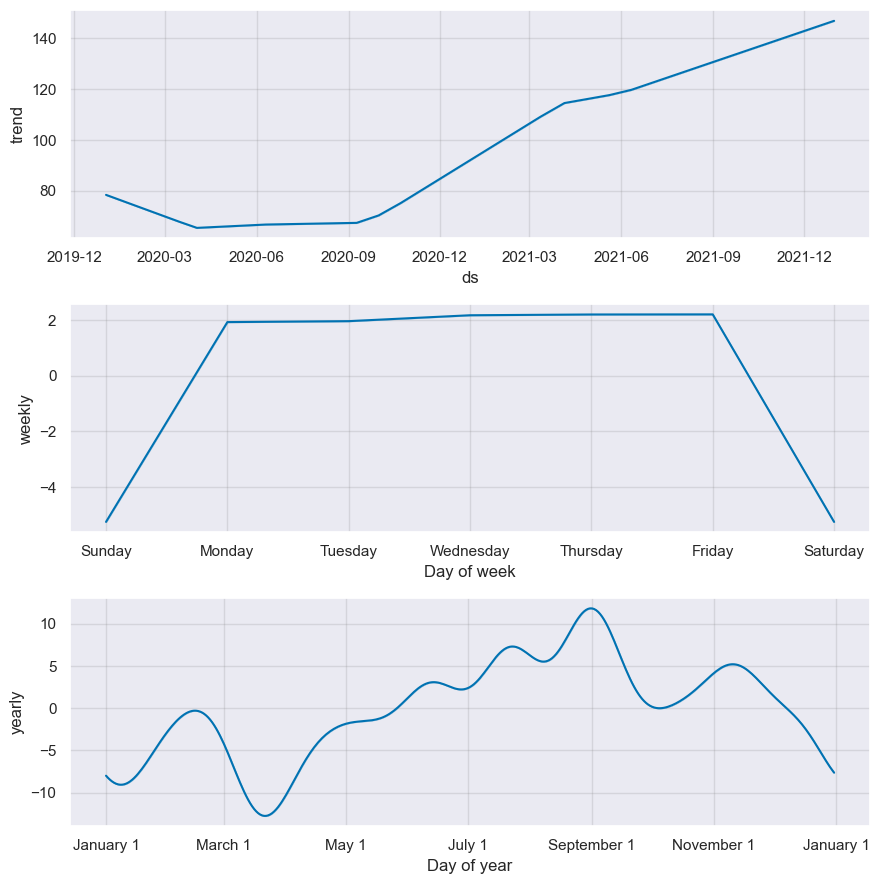

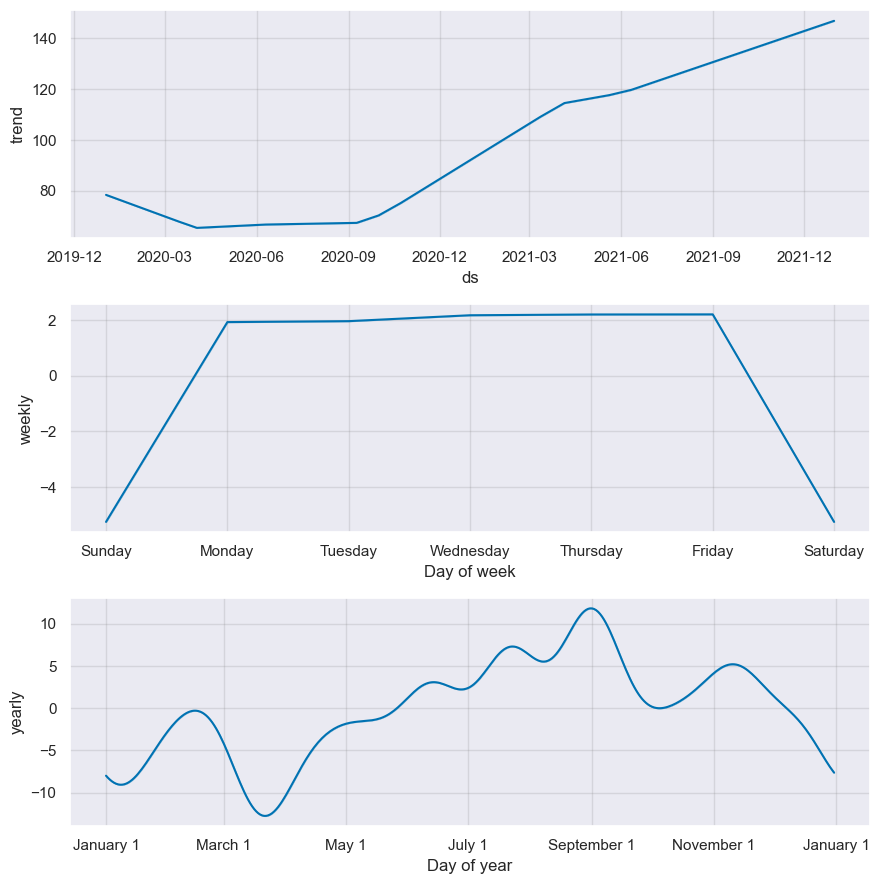

In [17]:
model_season.plot_components(forecast_season)

In [18]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 2.863484563933794
The MAPE for the seasonality model is 0.01967283178987061
The MAE for the seasonality model is 2.863484563933794
The MAPE for the seasonality model is 0.01967283178987061


--> Multivariate model. In this, we will explicitly command the model to include a third column, other than 'ds' and 'y'

In [19]:
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

model_multivariate.add_regressor('VTI', standardize=False)

model_multivariate.fit(train)

11:13:42 - cmdstanpy - INFO - Chain [1] start processing
11:13:42 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

print(future_multivariate)

future_multivariate = pd.merge(future_multivariate, data[['ds', 'VTI']], on='ds', how='inner')

future_multivariate = future_multivariate.fillna(method='ffill')

future_multivariate.tail(10)

            ds
0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
..         ...
505 2021-12-27
506 2021-12-28
507 2021-12-29
508 2021-12-30
509 2021-12-31

[510 rows x 1 columns]


C:\Users\Malhar.Pandya\AppData\Local\Temp\ipykernel_18092\2808919793.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_multivariate = future_multivariate.fillna(method='ffill')


,ds,VTI
495,2021-12-17,224.219391
496,2021-12-20,221.067139
497,2021-12-21,225.400314
498,2021-12-22,227.628799
499,2021-12-23,229.200134
500,2021-12-27,232.209839
501,2021-12-28,231.731934
502,2021-12-29,231.865753
503,2021-12-30,231.493027
504,2021-12-31,230.757065


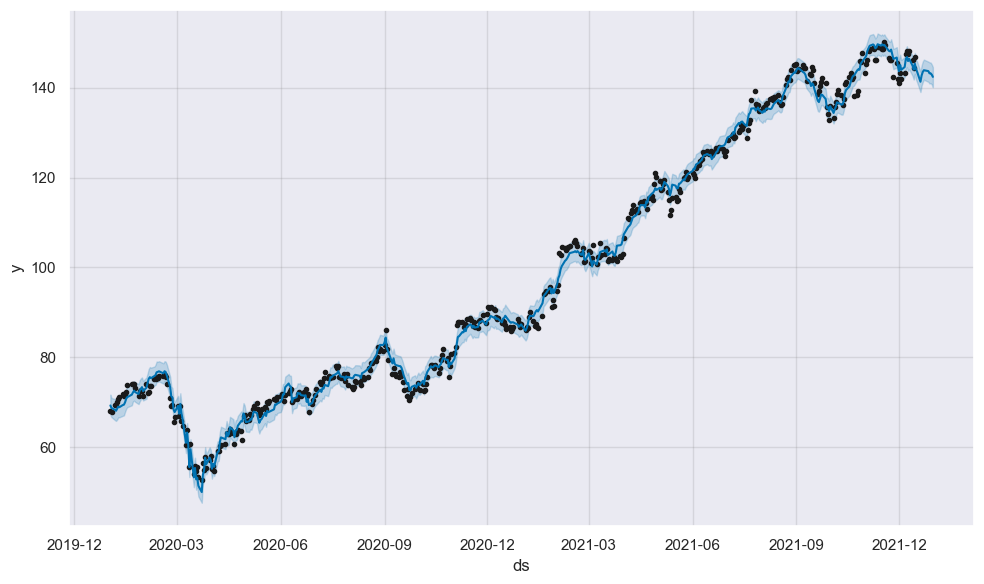

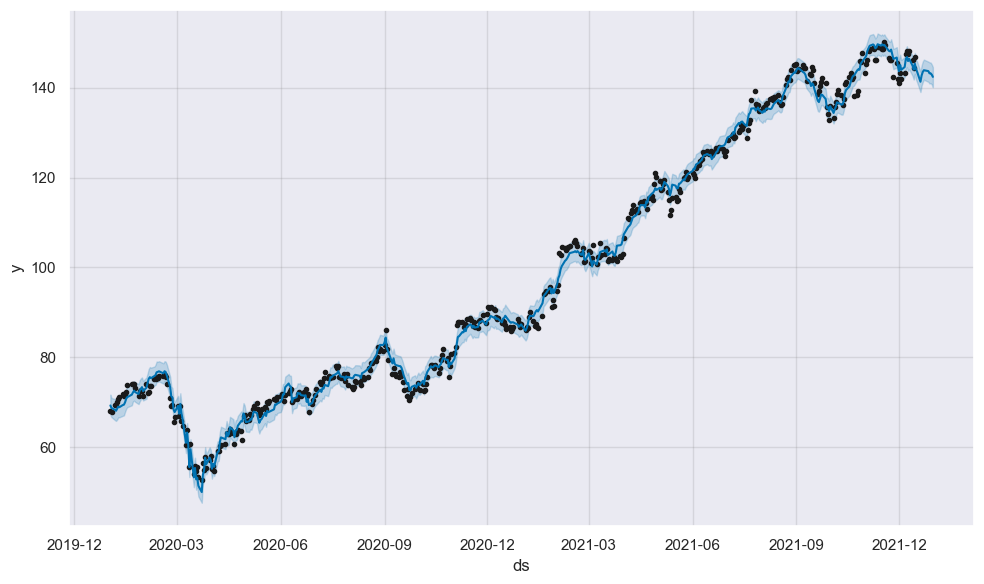

In [22]:
forecast_multivariate = model_multivariate.predict(future_multivariate)

model_multivariate.plot(forecast_multivariate)

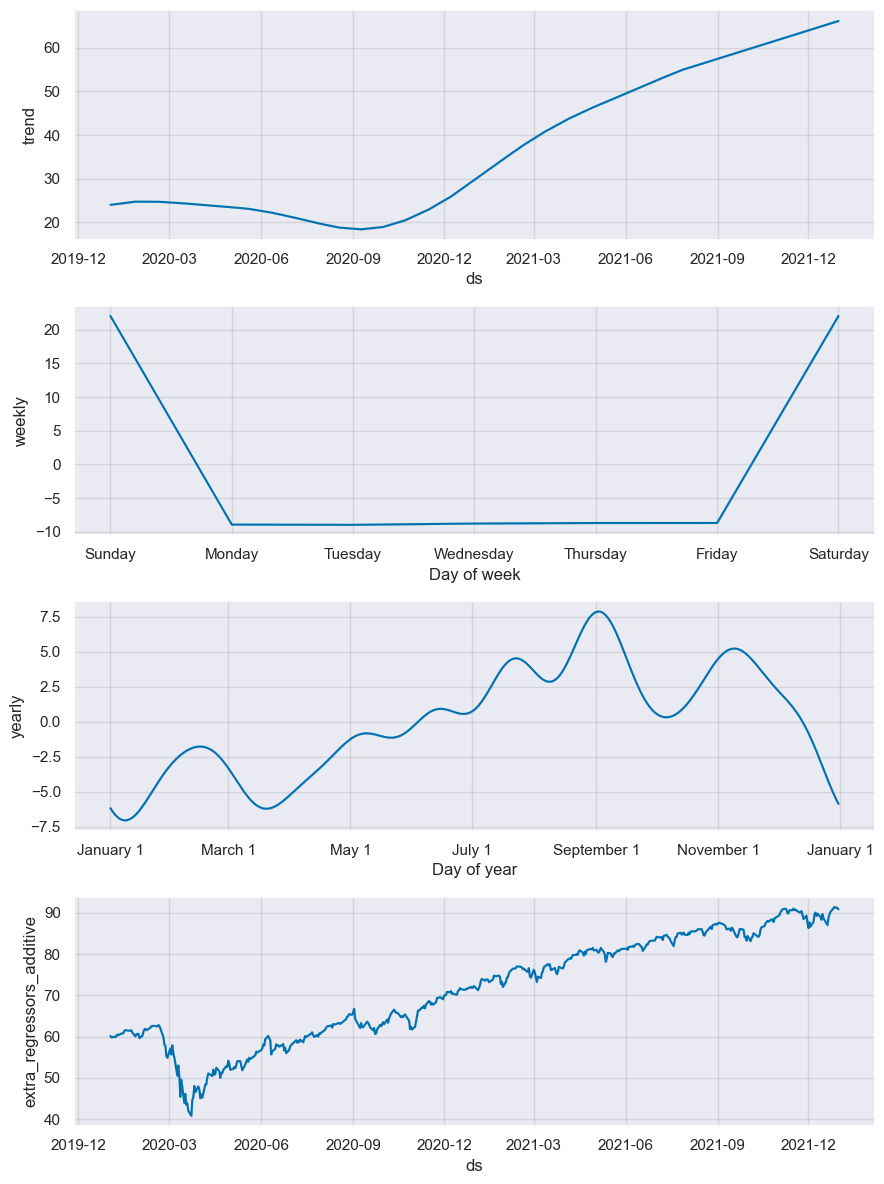

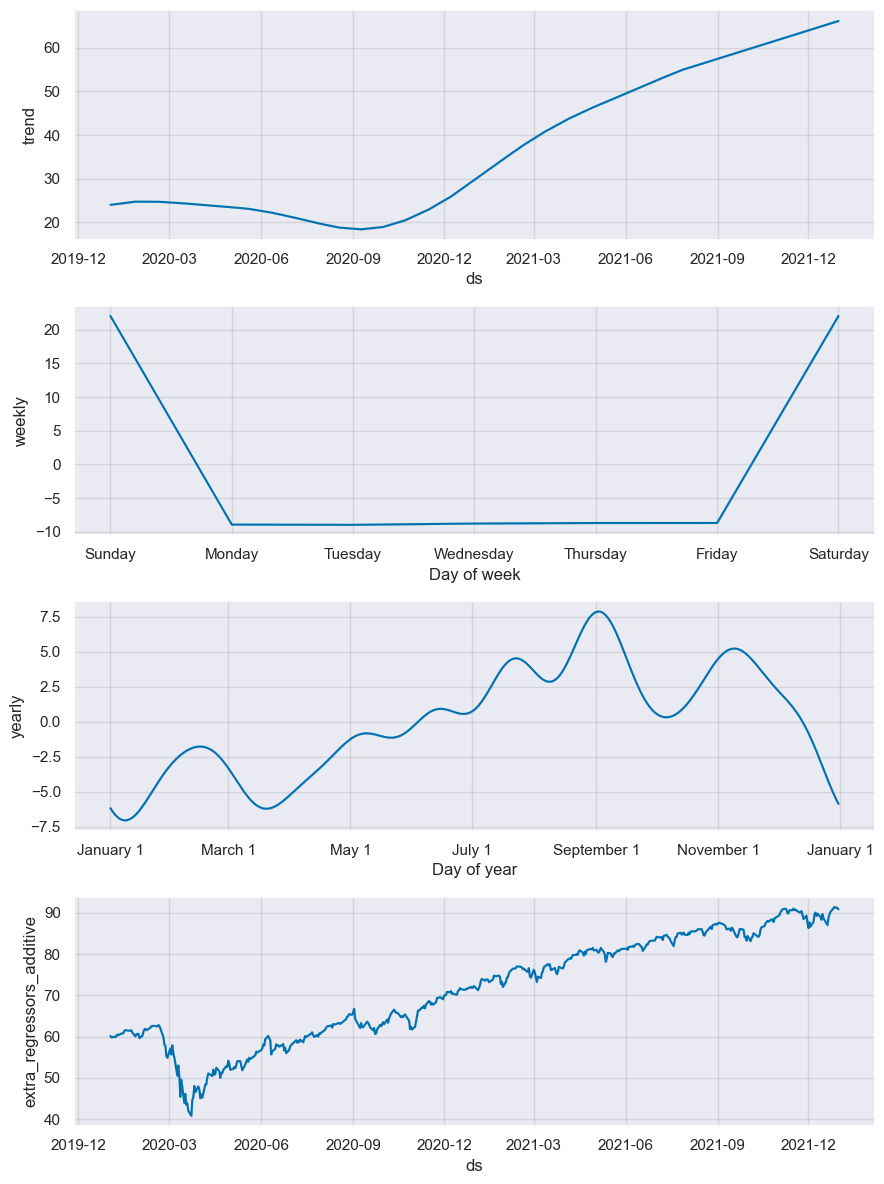

In [23]:
model_multivariate.plot_components(forecast_multivariate)

--> Multivariate Model Performance

In [24]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 2.036283399303647
The MAPE for the multivariate model is 0.013972762471996664


--> Model with holiday and event effect

In [25]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,    
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [26]:
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

model_holiday.add_country_holidays(country_name='US')

model_holiday.add_regressor('VTI', standardize=False)

model_holiday.fit(train)

model_holiday.train_holiday_names

11:20:10 - cmdstanpy - INFO - Chain [1] start processing
11:20:10 - cmdstanpy - INFO - Chain [1] done processing


0                                               COVID
1                                           superbowl
2                                      New Year's Day
3                                        Memorial Day
4                                    Independence Day
5                         Independence Day (observed)
6                                           Labor Day
7                                        Veterans Day
8                                        Thanksgiving
9                                       Christmas Day
10                         Martin Luther King Jr. Day
11                              Washington's Birthday
12                                       Columbus Day
13                          New Year's Day (observed)
14               Juneteenth National Independence Day
15    Juneteenth National Independence Day (observed)
16                           Christmas Day (observed)
dtype: object

C:\Users\Malhar.Pandya\AppData\Local\Temp\ipykernel_18092\1744297675.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_holiday = future_holiday.fillna(method='ffill')


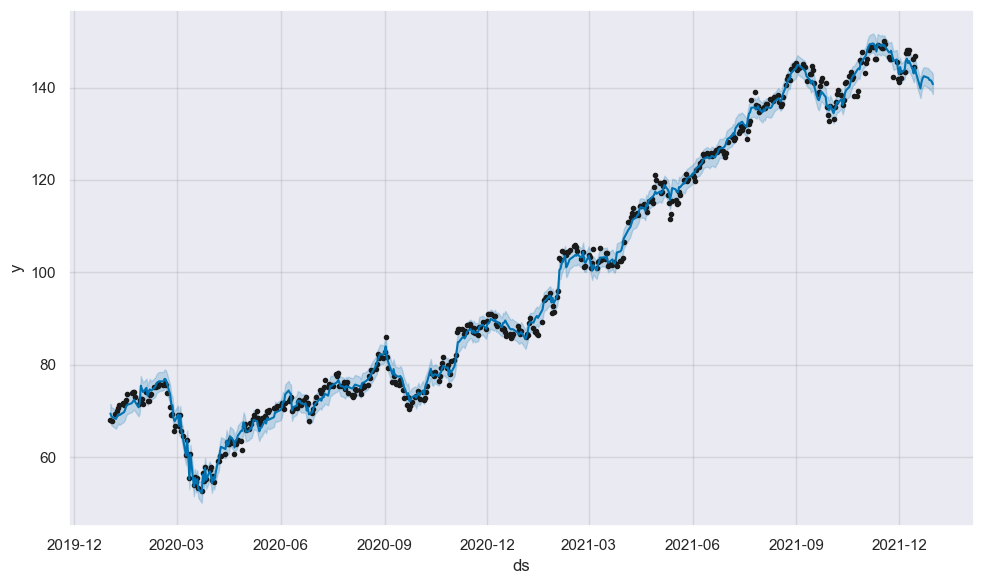

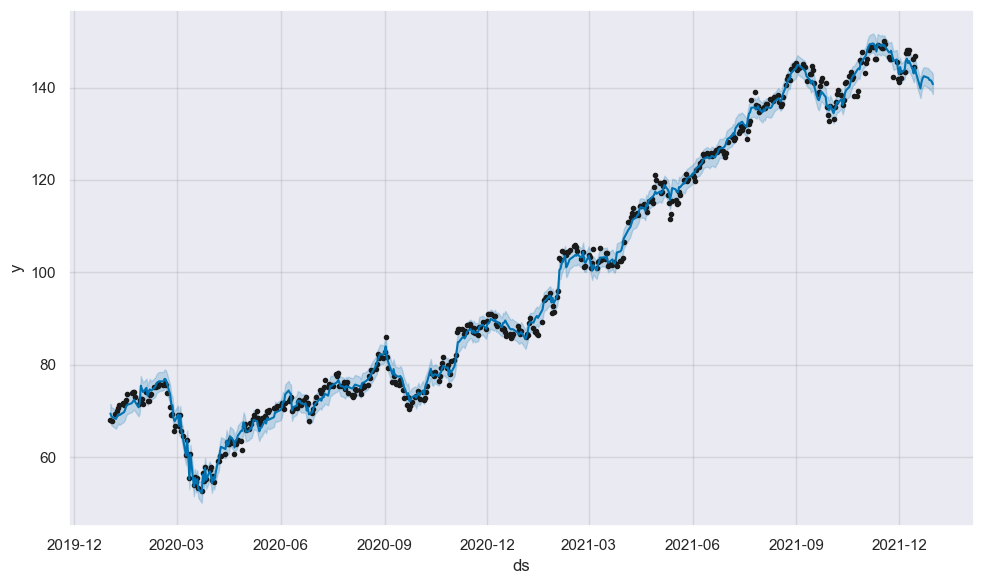

In [27]:
future_holiday = model_holiday.make_future_dataframe(periods=16)

future_holiday = pd.merge(future_holiday, data[['ds', 'VTI']], on='ds', how='inner')

future_holiday = future_holiday.fillna(method='ffill')

forecast_holiday = model_holiday.predict(future_holiday)

model_holiday.plot(forecast_holiday)

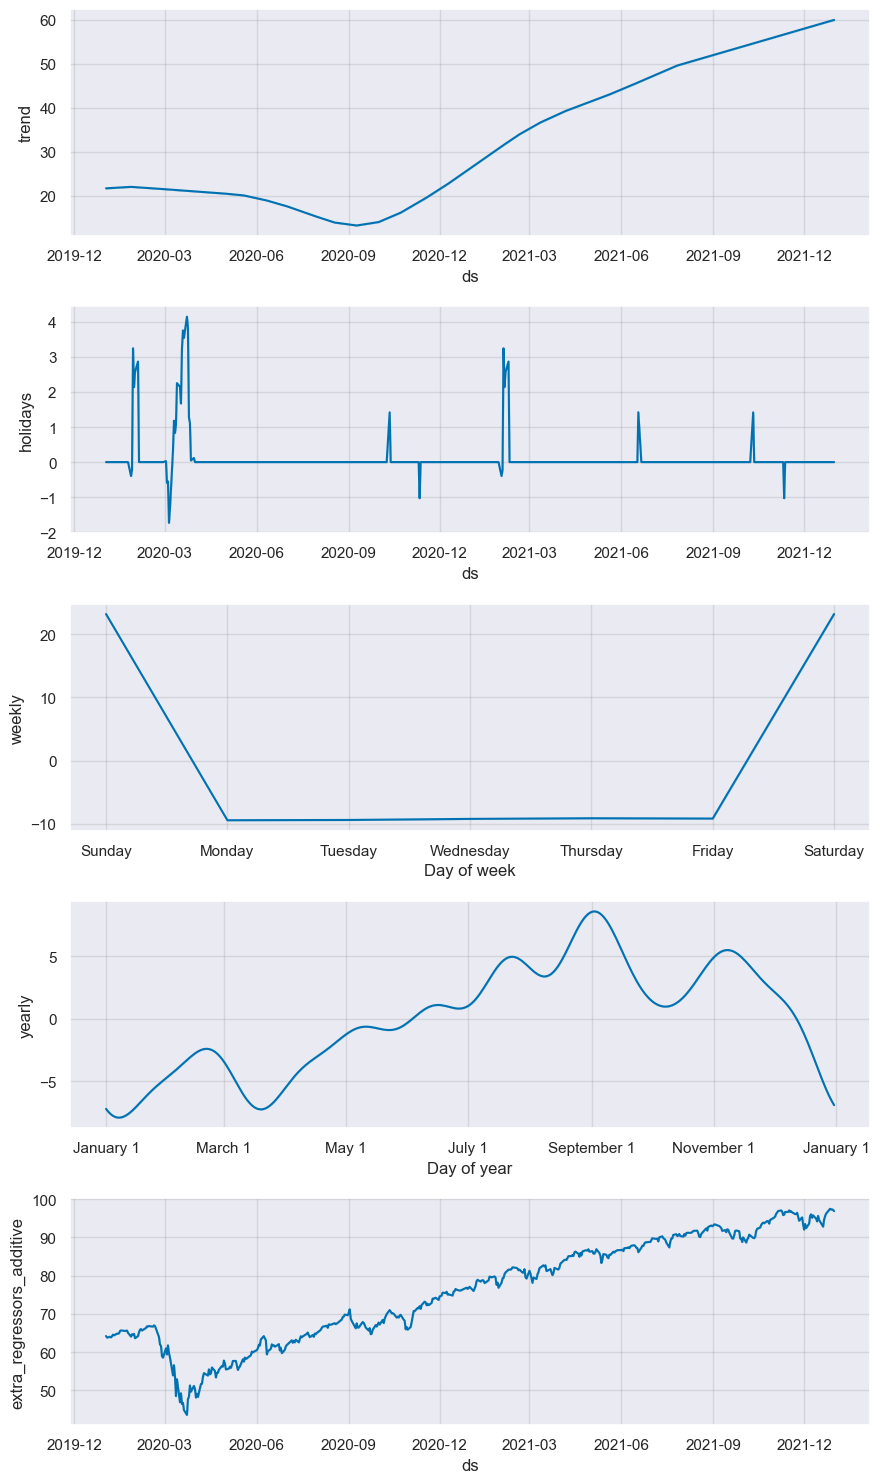

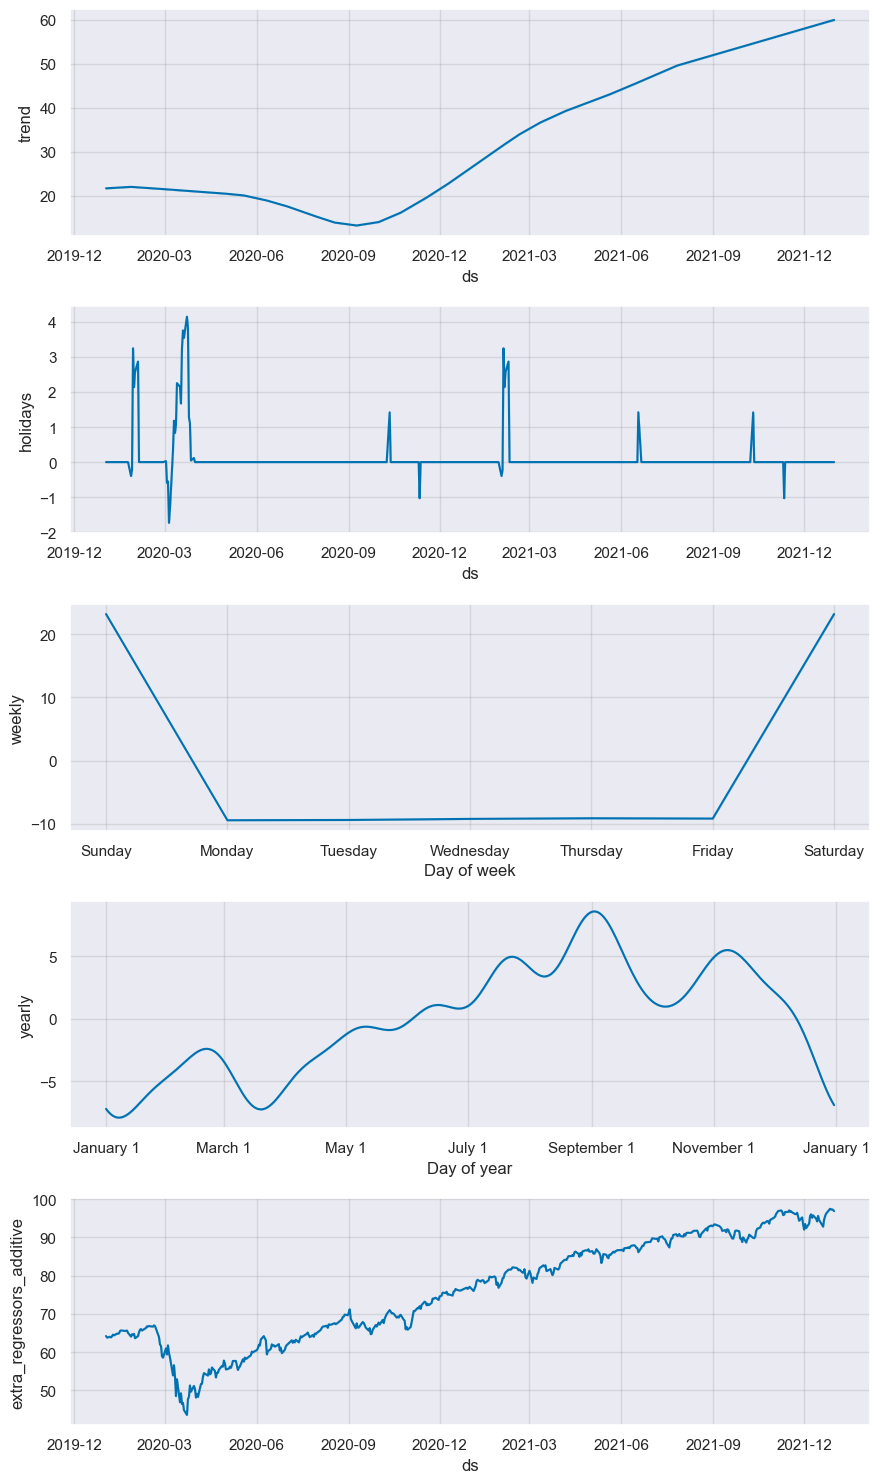

In [28]:
model_holiday.plot_components(forecast_holiday)

In [29]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 3.2746865516357673
The MAPE for the holiday/event model is 0.02248525615349033
